In [1]:
import mne
import numpy as np
import pandas as pd
from scipy.signal import coherence, hilbert

In [2]:
# ====== CONFIGURACIÓN ======
edf_path = r"C:\Users\V304-24\Documents\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf"
sfreq_target = 256            # Frecuencia de muestreo a la que normalizamos (Hz)
fmin, fmax = 8, 13            # Banda alfa para la coherencia (puedes ajustar)

In [3]:
# ====== CARGA Y PREPROCESAMIENTO ======
raw = mne.io.read_raw_edf(edf_path, preload=True)
raw.resample(sfreq_target)
raw.filter(1., 45., fir_design='firwin')
data = raw.get_data()
ch_names = raw.info['ch_names']
n_channels = len(ch_names)

Extracting EDF parameters from C:\Users\V304-24\Documents\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\V304-24\AppData\Local\Temp\ipykernel_18180\1692581060.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Sampling frequency of the instance is already 256.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



In [4]:
data

array([[-6.26804381e-20,  9.96691423e-05,  1.56464544e-04, ...,
        -3.25461886e-05, -2.44063872e-05, -3.38813179e-21],
       [ 0.00000000e+00,  7.14210275e-05,  1.12391959e-04, ...,
        -5.47231902e-06, -1.78326784e-06, -1.10114283e-20],
       [-8.47032947e-21,  3.00249387e-05,  4.62387169e-05, ...,
         1.76838641e-05,  1.13131737e-05, -8.47032947e-22],
       ...,
       [-5.08219768e-20,  1.84483340e-04,  2.87170890e-04, ...,
         3.62255574e-05,  1.60453355e-05,  5.08219768e-21],
       [-1.10114283e-20, -6.40667792e-05, -1.01071351e-04, ...,
         7.34684870e-06,  1.44976840e-06, -1.27054942e-21],
       [ 1.86347248e-20, -3.08754614e-05, -4.79904833e-05, ...,
        -8.25147645e-06, -5.29050421e-06,  1.16467030e-21]],
      shape=(23, 921600))

In [5]:
ch_names

['FP1-F7',
 'F7-T7',
 'T7-P7',
 'P7-O1',
 'FP1-F3',
 'F3-C3',
 'C3-P3',
 'P3-O1',
 'FP2-F4',
 'F4-C4',
 'C4-P4',
 'P4-O2',
 'FP2-F8',
 'F8-T8',
 'T8-P8-0',
 'P8-O2',
 'FZ-CZ',
 'CZ-PZ',
 'P7-T7',
 'T7-FT9',
 'FT9-FT10',
 'FT10-T8',
 'T8-P8-1']

In [6]:
n_channels

23

In [7]:
# ====== 1. MATRIZ DE CORRELACIÓN DE PEARSON ======
corr_matrix = np.corrcoef(data)
corr_df = pd.DataFrame(corr_matrix, index=ch_names, columns=ch_names)
corr_df.to_csv("connectivity_pearson.csv")

# ====== 2. MATRIZ DE COHERENCIA ESPECTRAL ======
coh_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        f, Cxy = coherence(data[i], data[j], fs=sfreq_target, nperseg=sfreq_target*2)
        mask = (f >= fmin) & (f <= fmax)
        coh_matrix[i, j] = np.mean(Cxy[mask])

coh_df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)
coh_df.to_csv("connectivity_coherence.csv")

# ====== 3. MATRIZ DE PHASE LOCKING VALUE (PLV) ======
analytic_signal = hilbert(data)
phase_data = np.angle(analytic_signal)

plv_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        phase_diff = phase_data[i] - phase_data[j]
        plv_matrix[i, j] = np.abs(np.sum(np.exp(1j * phase_diff)) / phase_diff.size)

plv_df = pd.DataFrame(plv_matrix, index=ch_names, columns=ch_names)


In [ ]:
## Tarea- En qué casos se utilza cada uno y en qué conviene
##  fs=sfreq_target, nperseg=sfreq_target*2- Averiguar para qué sirven estos

In [8]:
corr_df, coh_df, plv_df

(            FP1-F7     F7-T7     T7-P7     P7-O1    FP1-F3     F3-C3  \
 FP1-F7    1.000000  0.103592 -0.070391  0.008550  0.792282  0.402987   
 F7-T7     0.103592  1.000000  0.138700  0.005079  0.491057  0.419551   
 T7-P7    -0.070391  0.138700  1.000000  0.149314  0.118458  0.308218   
 P7-O1     0.008550  0.005079  0.149314  1.000000  0.013313  0.063706   
 FP1-F3    0.792282  0.491057  0.118458  0.013313  1.000000  0.302627   
 F3-C3     0.402987  0.419551  0.308218  0.063706  0.302627  1.000000   
 C3-P3     0.221081  0.195553  0.338679  0.383856  0.021996  0.393363   
 P3-O1     0.130110  0.135568  0.291802  0.580096  0.052724 -0.004858   
 FP2-F4    0.744005  0.384312  0.102540  0.044230  0.831614  0.357336   
 F4-C4     0.462771  0.217138  0.161603  0.158999  0.362011  0.526888   
 C4-P4     0.287408  0.090049  0.166814  0.203238  0.128821  0.434965   
 P4-O2     0.153786  0.069655  0.169576  0.488425  0.066738  0.093638   
 FP2-F8    0.736154  0.422422  0.074641  0.061181  

In [9]:
corr_df.columns

Index(['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3',
       'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8',
       'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10',
       'FT10-T8', 'T8-P8-1'],
      dtype='object')

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Actividades
1. Generar el mapa de calor de cada matriz de conectividad
2. Generar la distribución de cada datos de cada matriz de conectividad
3. ¿Qué valor se encuentra el percentil 0.75 de cada matriz de conectividad
4. Generar el grafo 2D de cada matriz de conectividad y compararlos
5. Generar el grafo 3D de cada matriz de conectividad y compararlos

##Terminar


<Axes: >

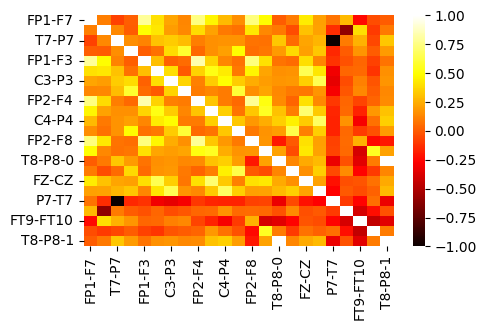

In [11]:
plt.figure(figsize=(5, 3))
sns.heatmap(corr_df, cmap='hot')

In [13]:
percentil_75= np.percentil(corr_df.values.flatten(), 75)


AttributeError: module 'numpy' has no attribute 'percentil'

(array([[ 0.,  0.,  0.,  1.,  2.,  8.,  4.,  4.,  3.,  1.],
        [ 0.,  0.,  1.,  0.,  3., 10.,  5.,  3.,  0.,  1.],
        [ 1.,  0.,  0.,  0.,  2., 11.,  8.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  1., 14.,  5.,  2.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  3., 11.,  3.,  2.,  2.,  2.],
        [ 0.,  0.,  0.,  1.,  2.,  7.,  5.,  6.,  1.,  1.],
        [ 0.,  0.,  0.,  1.,  2.,  7., 10.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  1.,  2., 14.,  3.,  2.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  2., 12.,  3.,  2.,  2.,  2.],
        [ 0.,  0.,  0.,  0.,  2.,  7.,  9.,  3.,  1.,  1.],
        [ 0.,  0.,  0.,  1.,  1.,  8.,  8.,  3.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  3., 13.,  3.,  2.,  1.,  1.],
        [ 0.,  0.,  0.,  1.,  4.,  7.,  4.,  3.,  3.,  1.],
        [ 0.,  0.,  0.,  1.,  2.,  6.,  7.,  6.,  0.,  1.],
        [ 0.,  0.,  0.,  2.,  2., 11.,  6.,  0.,  0.,  2.],
        [ 0.,  0.,  0.,  1.,  5., 12.,  2.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  1.,  2.,  4.,  

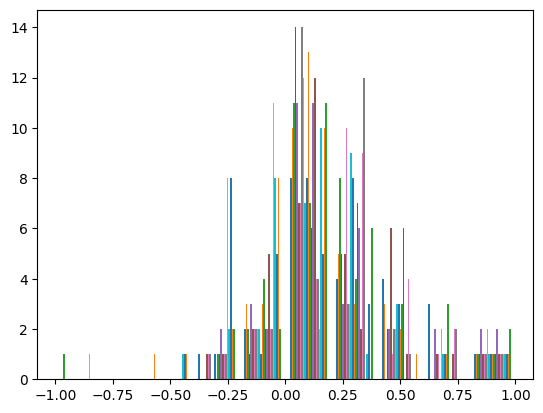

In [24]:
valores = np.random.uniform(size=50)
plt.hist(corr_df)   #si son más números va a haber un distribucion uniforme


In [14]:
corr_df.values

array([[ 1.        ,  0.10359249, -0.07039127,  0.00854959,  0.79228244,
         0.40298696,  0.22108051,  0.13011047,  0.74400498,  0.46277118,
         0.28740823,  0.15378569,  0.73615364,  0.48732234,  0.0038821 ,
         0.10085225,  0.43739214,  0.21056137,  0.07039127,  0.28201146,
        -0.24633841, -0.04015668,  0.0038821 ],
       [ 0.10359249,  1.        ,  0.13869975,  0.00507931,  0.49105683,
         0.41955147,  0.19555283,  0.13556752,  0.38431211,  0.21713773,
         0.09004933,  0.0696547 ,  0.42242181,  0.13733315,  0.09182676,
        -0.04368666,  0.30949244,  0.21124568, -0.13869975, -0.59908693,
         0.39556295, -0.09984979,  0.09182676],
       [-0.07039127,  0.13869975,  1.        ,  0.14931433,  0.1184582 ,
         0.30821845,  0.33867917,  0.29180183,  0.10253969,  0.1616032 ,
         0.16681446,  0.16957592,  0.07464144,  0.06339877,  0.32664574,
         0.05125565,  0.22498473,  0.2720336 , -1.        ,  0.10019522,
         0.26107365, -0.0600

<Axes: >

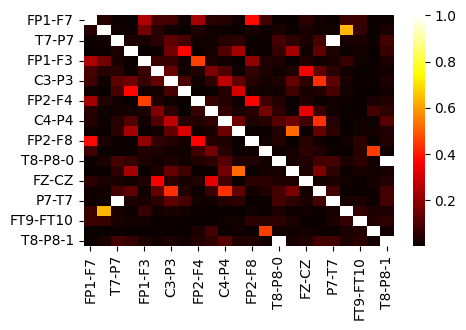

In [25]:
plt.figure(figsize=(5, 3))
sns.heatmap(coh_df, cmap='hot')

<Axes: >

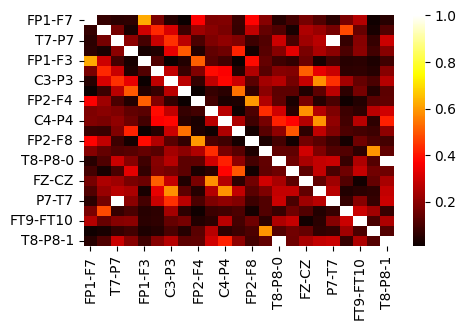

In [27]:
plt.figure(figsize=(5, 3))
sns.heatmap(plv_df, cmap='hot')

(array([[19.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.],
        [20.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.],
        [20.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
        [16.,  3.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.],
        [18.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  1.],
        [17.,  4.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.],
        [14.,  6.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.],
        [20.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.],
        [19.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.],
        [19.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.],
        [14.,  6.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.],
        [16.,  3.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.],
        [19.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  1.],
        [20.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.],
        [20.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
        [17.,  3.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.],
        [20.,  0.,  0.,  2.,  0.,  0.,  

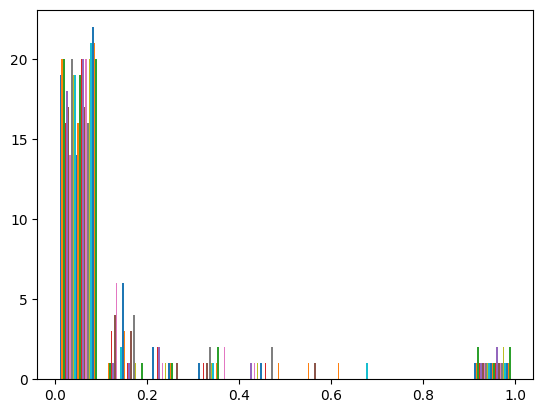

In [28]:
valores = np.random.uniform(size=50)
plt.hist(coh_df)   #si son más números va a haber un distribucion uniforme


(array([[11.,  7.,  1.,  2.,  0.,  0.,  1.,  0.,  0.,  1.],
        [ 6.,  8.,  5.,  1.,  2.,  0.,  0.,  0.,  0.,  1.],
        [ 7.,  7.,  6.,  0.,  1.,  0.,  0.,  0.,  0.,  2.],
        [ 8.,  9.,  1.,  2.,  2.,  0.,  0.,  0.,  0.,  1.],
        [14.,  4.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.],
        [ 6.,  7.,  4.,  3.,  1.,  1.,  0.,  0.,  0.,  1.],
        [ 4.,  3.,  9.,  3.,  2.,  1.,  0.,  0.,  0.,  1.],
        [11.,  6.,  3.,  0.,  1.,  1.,  0.,  0.,  0.,  1.],
        [12.,  5.,  2.,  1.,  0.,  2.,  0.,  0.,  0.,  1.],
        [ 7.,  6.,  6.,  1.,  1.,  1.,  0.,  0.,  0.,  1.],
        [ 6.,  6.,  4.,  3.,  2.,  1.,  0.,  0.,  0.,  1.],
        [11.,  5.,  3.,  0.,  2.,  1.,  0.,  0.,  0.,  1.],
        [13.,  4.,  2.,  2.,  0.,  1.,  0.,  0.,  0.,  1.],
        [ 2., 15.,  3.,  0.,  1.,  1.,  0.,  0.,  0.,  1.],
        [ 4.,  9.,  7.,  0.,  1.,  0.,  0.,  0.,  0.,  2.],
        [ 8.,  9.,  2.,  2.,  1.,  0.,  0.,  0.,  0.,  1.],
        [ 3.,  9.,  8.,  0.,  0.,  2.,  

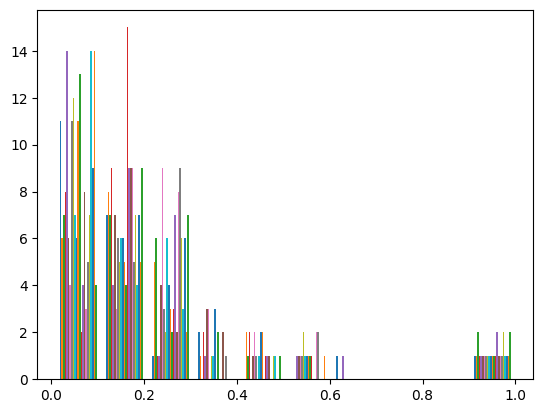

In [29]:
valores = np.random.uniform(size=50)
plt.hist(plv_df)   #si son más números va a haber un distribucion uniforme


In [30]:
import networkx as nx

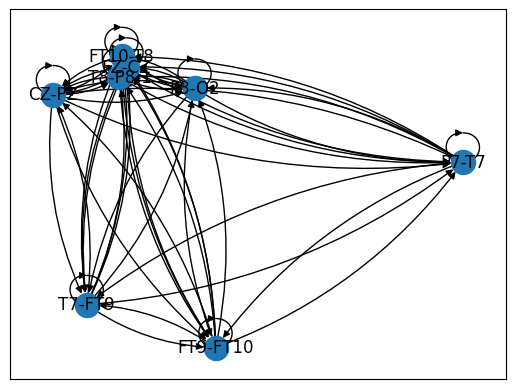

In [33]:
corr_df = pd.DataFrame(corr_matrix, index=ch_names, columns=ch_names)


G = nx.from_pandas_adjacency(corr_df.iloc[15: 35, 15: 35], create_using=nx.DiGraph())

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, arrows=True, arrowstyle='-|>', connectionstyle='arc3,rad=0.15')

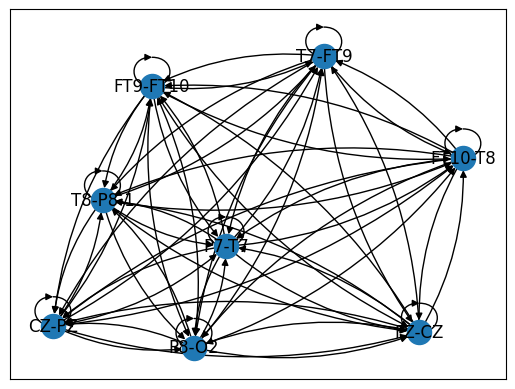

In [37]:
coh_df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)


G = nx.from_pandas_adjacency(coh_df.iloc[15: 35, 15: 35], create_using=nx.DiGraph())

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, arrows=True, arrowstyle='-|>', connectionstyle='arc3,rad=0.15')

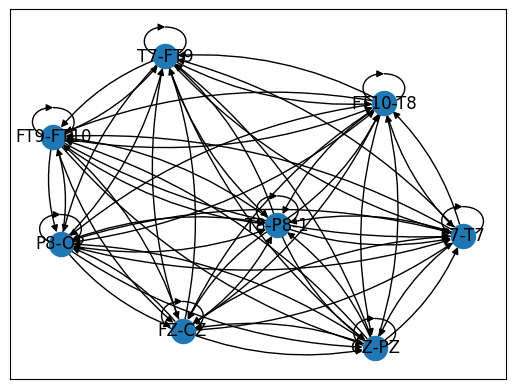

In [36]:
plv_df = pd.DataFrame(plv_matrix, index=ch_names, columns=ch_names)


G = nx.from_pandas_adjacency(plv_df.iloc[15: 35, 15: 35], create_using=nx.DiGraph())

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, arrows=True, arrowstyle='-|>', connectionstyle='arc3,rad=0.15')